In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import xgboost as xgb

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:
from src.paths import TRANSFORMED_DATA_DIR, VISUALIZATIONS_DIR
from src.plot import plot_actual_predicted_scatter

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'tabular_data.parquet')
df

,rides_previous_672_hour,rides_previous_671_hour,rides_previous_670_hour,rides_previous_669_hour,rides_previous_668_hour,rides_previous_667_hour,rides_previous_666_hour,rides_previous_665_hour,rides_previous_664_hour,rides_previous_663_hour,...,rides_previous_7_hour,rides_previous_6_hour,rides_previous_5_hour,rides_previous_4_hour,rides_previous_3_hour,rides_previous_2_hour,rides_previous_1_hour,pickup_hour,pickup_location_id,target_rides_next_hour
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-29,1,0.0
1,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2023-01-30,1,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,0.0,2023-01-31,1,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-02-01,1,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-02,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89300,1.0,0.0,2.0,0.0,0.0,3.0,3.0,0.0,3.0,2.0,...,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2023-12-27,265,3.0
89301,5.0,7.0,2.0,1.0,0.0,1.0,2.0,2.0,3.0,3.0,...,6.0,4.0,2.0,4.0,10.0,3.0,3.0,2023-12-28,265,1.0
89302,5.0,3.0,2.0,3.0,1.0,3.0,1.0,5.0,3.0,1.0,...,3.0,1.0,8.0,5.0,1.0,0.0,6.0,2023-12-29,265,5.0
89303,3.0,4.0,9.0,4.0,1.0,2.0,0.0,0.0,0.0,2.0,...,6.0,3.0,2.0,2.0,5.0,1.0,5.0,2023-12-30,265,2.0


In [5]:
from src.data_split import train_test_split
from src.evaluation import evaluate_metrics, save_metrics

In [6]:
X_train, y_train, X_test, y_test = train_test_split(df, 
                                                    cutoff_date=datetime(2023, 6, 1, 0, 0, 0),
                                                    target_column_name='target_rides_next_hour')

In [7]:
print(f'Datasets shapes')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Datasets shapes
X_train: (32595, 674)
y_train: (32595,)
X_test: (56710, 674)
y_test: (56710,)


In [8]:
past_rides_columns = [col for col in X_train.columns if col.startswith('rides_')]
X_train_only_numeric = X_train[past_rides_columns]

In [9]:
model = xgb.XGBRegressor(randon_state=42)
model.fit(X_train_only_numeric, y_train)

/Users/cmartinez/anaconda3/envs/python39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "randon_state" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
X_test_only_numeric = X_test[past_rides_columns]
predictions = model.predict(X_test_only_numeric)
predictions

array([0.2442956 , 0.0779363 , 0.07114223, ..., 6.429553  , 6.6765933 ,
       4.977697  ], dtype=float32)

In [11]:
xgboost_predictions = predictions.copy() 
residuals = y_test - xgboost_predictions 

In [12]:
metrics = evaluate_metrics(y_test, predictions)

for metric, value in metrics.items():
    print(f'{metric}: {value:.2f}')

MAE: 3.15
MSE: 153.59
RMSE: 12.39
SMAPE: 150.66
R: 0.95
R-squared: 0.90


In [13]:
model_name = 'XGBoostRegressor'
metrics['Model'] = model_name
save_metrics(metrics)

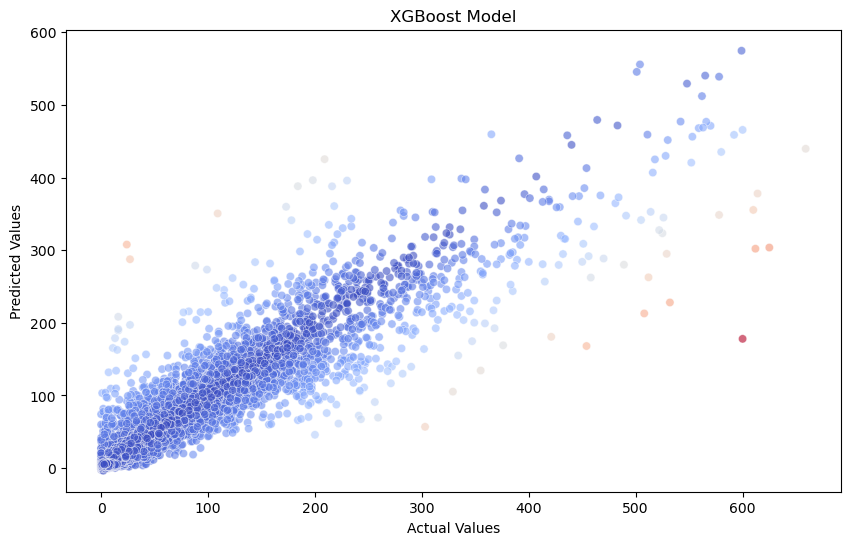

In [14]:
title = 'XGBoost Model'
file_name = 'xgboost_scatter.png'
output_dir = VISUALIZATIONS_DIR

plot_actual_predicted_scatter(y_test, predictions, residuals, output_dir, title, file_name)

/Users/cmartinez/anaconda3/envs/python39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


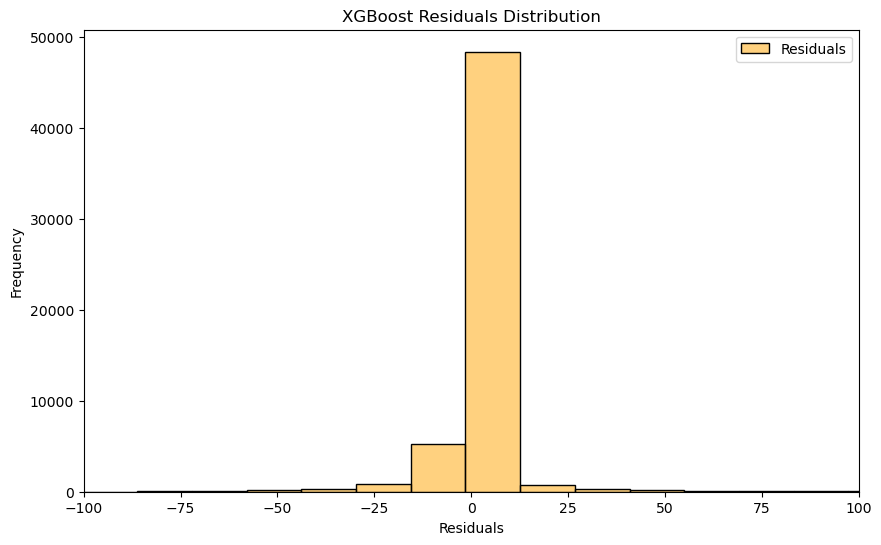

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, color='orange', label='Residuals', alpha=0.5)
plt.xlim(-100, 100)
plt.title('XGBoost Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(VISUALIZATIONS_DIR / 'xgboost_residuals.png')
plt.show()